## SMS pipeline: run + map stiffness to CT
- Toggle `RUN_SMS` to execute `scripts/sms_reg_alpha_lbfgs.py` (long-running).
- Map `alpha` onto the CT grid (masked to lung) via `visualize_notebooks/map_stiffness_to_image.py`.
- Downstream cells reuse `XDMF_PATH`/visualizations as before.


In [7]:
import os
from pathlib import Path
import subprocess, sys

NOTEBOOK_ROOT = Path(os.getcwd())
if '__file__' in globals():
    NOTEBOOK_ROOT = Path(__file__).resolve().parent
REPO_ROOT = NOTEBOOK_ROOT.parent
SCRIPTS_DIR = REPO_ROOT / 'scripts'
VIS_NOTEBOOKS_DIR = REPO_ROOT / 'visualize_notebooks'

SMS_SCRIPT = SCRIPTS_DIR / 'sms_reg_alpha_lbfgs.py'
MAP_SCRIPT = VIS_NOTEBOOKS_DIR / 'map_stiffness_to_image.py'

DATA_ROOT = REPO_ROOT / 'data/Emory-4DCT'
SUBJECT = 'Case5Pack'            # e.g., Case5Pack
CT_STEM = 'case5'                # filename stem used under NIFTI (e.g., case5_T40.nii.gz)
FIXED_STATE = 'T40'              # matches CT filename suffix and sms fixed-state
MOVING_STATE = 'T10'             # sms moving-state
VARIANT = 'NIFTI'

RUN_SMS = True                  # set True to launch optimization (CUDA/long runtime)
SAVE_NPY = False                 # optionally dump mapped volume as .npy
MAP_METHOD = 'hybrid'            # linear | nearest | hybrid
MAP_FILL_VALUE = float('nan')
MASK_NAME = 'lung_combined_mask.nii.gz'

RESULTS_DIR = SCRIPTS_DIR / 'results' / 'sms_global_local_1.0'
SCENARIO_LOCAL_DIR = RESULTS_DIR / 'stage2_local'


In [8]:
def run_sms():
    cmd = [
        sys.executable, str(SMS_SCRIPT),
        '--data-root', str(DATA_ROOT),
        '--subject', SUBJECT,
        '--fixed-state', FIXED_STATE,
        '--moving-state', MOVING_STATE,
        '--variant', VARIANT,
        '--mask-name', 'lung_regions',
        '--mesh-tag', 'lung_regions_11',
    ]
    print('Running SMS:', ' '.join(cmd))
    subprocess.run(cmd, check=True)

GENERATED_XDMF_PATH = None
if RUN_SMS:
    run_sms()

SMS_XDMF_PATH = SCENARIO_LOCAL_DIR / 'final_params.xdmf'
if SMS_XDMF_PATH.exists():
    GENERATED_XDMF_PATH = SMS_XDMF_PATH
    print(f'Found sms output: {SMS_XDMF_PATH}')
else:
    print(f'SMS output not found at {SMS_XDMF_PATH}; set GENERATED_XDMF_PATH manually if needed.')


Running SMS: /home/haozhe/miniconda3/envs/lung-project/bin/python /home/haozhe/Lung_Mesh_Segment/scripts/sms_reg_alpha_lbfgs.py --data-root /home/haozhe/Lung_Mesh_Segment/data/Emory-4DCT --subject Case5Pack --fixed-state T40 --moving-state T10 --variant NIFTI --mask-name lung_regions --mesh-tag lung_regions_11
[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.14
SMS INVERSE PROBLEM (global scalar + local field)
Emory case: Case5Pack T40->T10 (variant=NIFTI)
Mask: lung_regions, mesh tag: lung_regions_11
Step caps: dtheta=5.000e-01, ddelta=2.500e-01 | Global max iters: 1, warp max iters: 100
Precomputing deformation data via utils/sms_precompute.py (uses deformation_processor_v2.py on CUDA).
Running deformation preprocessing via helper: /home/haozhe/miniconda3/envs/lung-project/bin/python /home/haozhe/Lung_Mesh_Segment/scripts/utils/sms_precompute.py --mesh /home/haozhe/Lung_Mesh_Segment/data/Emory-4DCT/Case5Pack/pygalmesh/case5_T40_lung_regions_11.xdmf --displacem

/home/haozhe/Lung_Mesh_Segment/scripts/sms_reg_alpha_lbfgs.py:750: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return A_coo.to_sparse_csr()


[Step] solving baseline system for observed displacement
Mean observed displacement (free DOF): 1.328509e-03 m
[Init] alpha stats -- min=3.652e+03, max=9.173e+03
Saved parameter heatmap to /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_global_local_1.0/stage1_global/initial_params.xdmf
Saved parameter heatmap to /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_global_local_1.0/stage2_local/initial_params.xdmf
[Global-Coarse] starting optimization (history dir: /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_global_local_1.0/stage1_global)
[Local-Fine] starting optimization (history dir: /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_global_local_1.0/stage2_local)
[Global-Coarse] assembling stiffness matrix (closure)
[Global-Coarse] forward solve (closure)
[Global-Coarse][closure] loss=1.026502e+00, loss_data=9.962138e-01, loss_reg=3.028786e-02
[Global-Coarse] assembling stiffness matrix (closure)
[Global-Coarse] forward solve (closure)
[Global-Coarse][closure] loss=1.02262

In [6]:
ct_path = DATA_ROOT / SUBJECT / VARIANT / f"{CT_STEM}_{FIXED_STATE}.nii.gz"
if not ct_path.exists():
    raise FileNotFoundError(f'CT not found at {ct_path}; update CT_STEM/FIXED_STATE/SUBJECT.')

default_xdmf = SCENARIO_LOCAL_DIR / 'final_params.xdmf'
mapping_xdmf = None
if GENERATED_XDMF_PATH is not None and GENERATED_XDMF_PATH.exists():
    mapping_xdmf = GENERATED_XDMF_PATH
elif default_xdmf.exists():
    mapping_xdmf = default_xdmf

MAPPED_VOLUME_PATH = SCENARIO_LOCAL_DIR / f"{ct_path.stem}_alpha_map.nii.gz"

if mapping_xdmf is not None and mapping_xdmf.exists():
    cmd = [
        sys.executable, str(MAP_SCRIPT),
        '--mesh', str(mapping_xdmf),
        '--field', 'alpha',
        '--location', 'cell',
        '--image', str(ct_path),
        '--infer-mask',
        '--mask-name', MASK_NAME,
        '--method', MAP_METHOD,
        '--fill-value', str(MAP_FILL_VALUE),
        '--output', str(MAPPED_VOLUME_PATH),
    ]
    if SAVE_NPY:
        cmd += ['--save-npy', str(MAPPED_VOLUME_PATH.with_suffix('.npy'))]
    print('Mapping stiffness to CT:', ' '.join(cmd))
    subprocess.run(cmd, check=True)
    print(f'Mapped stiffness saved to {MAPPED_VOLUME_PATH}')
else:
    print('Skip mapping: no XDMF available; run SMS or update mapping_xdmf.')


Mapping stiffness to CT: /home/haozhe/miniconda3/envs/lung-project/bin/python /home/haozhe/Lung_Mesh_Segment/visualize_notebooks/map_stiffness_to_image.py --mesh /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_global_local_1.0/stage2_local/final_params.xdmf --field alpha --location cell --image /home/haozhe/Lung_Mesh_Segment/data/Emory-4DCT/Case5Pack/NIFTI/case5_T40.nii.gz --infer-mask --mask-name lung_combined_mask.nii.gz --method hybrid --fill-value nan --output /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_global_local_1.0/stage2_local/case5_T40.nii_alpha_map.nii.gz
Inferred mask path: /home/haozhe/Lung_Mesh_Segment/data/Emory-4DCT/Case5Pack/TotalSegment/case5_T40/lung_combined_mask.nii.gz
0/136018 samples (0.0%) fall inside the image grid
Applied mask to interpolated volume.
Wrote interpolated stiffness volume -> /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_global_local_1.0/stage2_local/case5_T40.nii_alpha_map.nii.gz
Mapped stiffness saved to /home/haozhe/Lung_Mesh_Se

# sms.py result visualization
**Workflow**

1. Configure the path to the `final_params.xdmf` (or any other `.xdmf` written by `sms.py`).
2. Load the mesh + `alpha` field and validate metadata.
3. Plot a histogram of `alpha` values and show summary stats.
4. Render the lung mesh with PyVista, coloring by `alpha`.

In [18]:
from pathlib import Path

DEFAULT_XDMF = Path('/home/haozhe/Lung_Mesh_Segment/scripts/results/sms_alpha_direct/alpha_final.xdmf')
XDMF_PATH = globals().get('GENERATED_XDMF_PATH', DEFAULT_XDMF)

print(f'Configured mesh path: {XDMF_PATH}')
if not XDMF_PATH.exists():
    raise FileNotFoundError(
        'Update XDMF_PATH with the path printed by sms_reg_alpha_lbfgs.py (final_params.xdmf).'
    )


Configured mesh path: /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_alpha_direct/alpha_final.xdmf


In [19]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import meshio
import numpy as np
import pandas as pd
import pyvista as pv

# Enable inline plots + optional off-screen rendering for headless servers
%matplotlib inline
try:
    pv.start_xvfb()
except Exception:
    pass



/home/haozhe/miniconda3/envs/lung-project/lib/python3.10/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


In [20]:
RESULTS_ROOT = XDMF_PATH.parent.parent
SCENARIO = XDMF_PATH.parent.name
print(f"Results root: {RESULTS_ROOT}")
print(f"Scenario dir: {XDMF_PATH.parent}")
print(f"Mesh path: {XDMF_PATH}")


Results root: /home/haozhe/Lung_Mesh_Segment/scripts/results
Scenario dir: /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_alpha_direct
Mesh path: /home/haozhe/Lung_Mesh_Segment/scripts/results/sms_alpha_direct/alpha_final.xdmf


In [21]:
mesh = meshio.read(XDMF_PATH)
pv_mesh = pv.from_meshio(mesh)

if 'alpha' not in pv_mesh.cell_data:
    raise KeyError("alpha field missing from mesh; rerun sms.py with save_parameter_heatmap enabled.")

alpha_values = np.asarray(pv_mesh.cell_data['alpha'], dtype=float)
labels = np.asarray(pv_mesh.cell_data['labels']) if 'labels' in pv_mesh.cell_data else None

pv_mesh.cell_data['alpha'] = alpha_values  # ensure float view for plotting
pv_mesh.set_active_scalars('alpha')

print(f"Mesh: {mesh.points.shape[0]} points, alpha field for {alpha_values.size} tetrahedra")
if labels is not None:
    unique_labels = np.unique(labels)
    print(f"Label ids present: {unique_labels}")

Mesh: 25056 points, alpha field for 136018 tetrahedra
Label ids present: [1 2 3 4 5 6 7]


### Alpha percentile clipping & log-scale view
Use percentiles (defaults: 1% - 99%) to focus on the bulk of the distribution and avoid huge outliers dominating the visualization.

In [22]:
ALPHA_PCTL_LOW = float(os.environ.get('SMS_ALPHA_PCTL_LOW', 1.0))
ALPHA_PCTL_HIGH = float(os.environ.get('SMS_ALPHA_PCTL_HIGH', 99.0))
alpha_vmin, alpha_vmax = np.percentile(alpha_values, [ALPHA_PCTL_LOW, ALPHA_PCTL_HIGH])
if alpha_vmin <= 0:
    positive_alpha = alpha_values[alpha_values > 0]
    alpha_vmin = positive_alpha.min() if positive_alpha.size else 1e-6
ALPHA_CLIM = (float(alpha_vmin), float(alpha_vmax))
print(f"alpha clipping percentiles: {ALPHA_PCTL_LOW}-{ALPHA_PCTL_HIGH}% -> [{ALPHA_CLIM[0]:.3e}, {ALPHA_CLIM[1]:.3e}]")

alpha clipping percentiles: 1.0-99.0% -> [3.000e+03, 1.000e+04]


Inlier samples: 136018/136018 (100.00%); outliers=0.00%


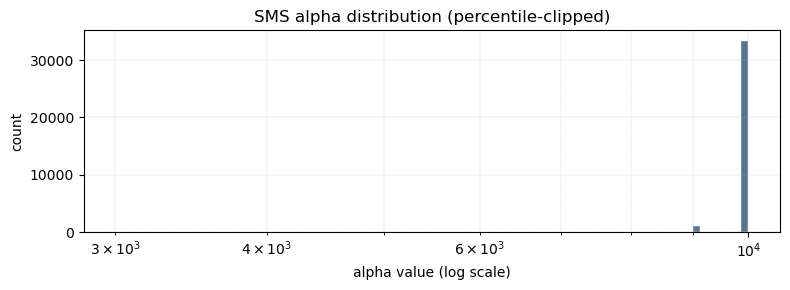

In [23]:
alpha_mask = (alpha_values >= ALPHA_CLIM[0]) & (alpha_values <= ALPHA_CLIM[1])
alpha_inliers = alpha_values[alpha_mask]
outlier_frac = 100.0 * (1.0 - alpha_inliers.size / alpha_values.size)

fig, ax = plt.subplots(figsize=(8, 3))
bins = np.logspace(np.log10(ALPHA_CLIM[0]), np.log10(ALPHA_CLIM[1]), 80)
ax.hist(alpha_inliers, bins=bins, color='#577590', edgecolor='white')
ax.set_xscale('log')
ax.set_xlabel('alpha value (log scale)')
ax.set_ylabel('count')
ax.set_title('SMS alpha distribution (percentile-clipped)')
ax.grid(True, which='both', linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
print(f"Inlier samples: {alpha_inliers.size}/{alpha_values.size} ({100.0 - outlier_frac:.2f}%); outliers={outlier_frac:.2f}%")

,alpha
count,136018.000000
mean,4778.117602
std,3038.324634
min,3000.000000
5%,3000.000000
50%,3000.000000
95%,10000.000000
max,10000.000000


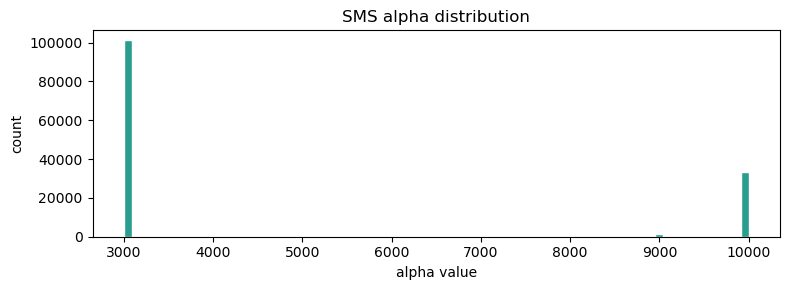

In [24]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(alpha_values, bins=80, color='#2a9d8f', edgecolor='white')
ax.set_xlabel('alpha value')
ax.set_ylabel('count')
ax.set_title('SMS alpha distribution')
plt.tight_layout()

summary = pd.Series(alpha_values).describe(percentiles=[0.05, 0.5, 0.95]).to_frame('alpha')
display(summary)

In [25]:
surface = pv_mesh.extract_surface()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(
    surface,
    scalars='alpha',
    cmap='viridis',
    show_edges=False,
    scalar_bar_args={'title': 'alpha'},
    clim=ALPHA_CLIM,
)
plotter.show()

Widget(value='<iframe src="http://localhost:39051/index.html?ui=P_0x70e4b6e916c0_3&reconnect=auto" class="pyvi…

## Young's Modulus (E) derived from SMS `alpha`

`scripts/sms.py` stores per-tetra `alpha_k = μ/2`. Given a Poisson ratio `ν`, we can recover the Young's modulus via `E = 2μ(1+ν) = 4α(1+ν)` . The default `ν=0.4` matches the solver configuration, but you can override it with the `SMS_POISSON` environment variable.

In [26]:
NU = float(os.environ.get('SMS_POISSON', 0.4))
mu_values = 2.0 * alpha_values
E_values = 2.0 * mu_values * (1.0 + NU)

pv_mesh.cell_data['E'] = E_values
print(f"Using nu = {NU:.3f}")
print(f"E stats: min={E_values.min():.3e}, max={E_values.max():.3e}, mean={E_values.mean():.3e}")

Using nu = 0.400
E stats: min=1.680e+04, max=5.600e+04, mean=2.676e+04


In [27]:
E_PCTL_LOW = float(os.environ.get('SMS_E_PCTL_LOW', ALPHA_PCTL_LOW))
E_PCTL_HIGH = float(os.environ.get('SMS_E_PCTL_HIGH', ALPHA_PCTL_HIGH))
E_vmin, E_vmax = np.percentile(E_values, [E_PCTL_LOW, E_PCTL_HIGH])
if E_vmin <= 0:
    positive_E = E_values[E_values > 0]
    E_vmin = positive_E.min() if positive_E.size else 1e-6
E_CLIM = (float(E_vmin), float(E_vmax))
print(f"E clipping percentiles: {E_PCTL_LOW}-{E_PCTL_HIGH}% -> [{E_CLIM[0]:.3e}, {E_CLIM[1]:.3e}]")

E clipping percentiles: 1.0-99.0% -> [1.680e+04, 5.600e+04]


E inliers: 136018/136018 (100.00%); outliers=0.00%


,E
count,136018.000000
mean,26757.458572
std,17014.617951
min,16800.000000
5%,16800.000000
50%,16800.000000
95%,56000.000000
max,56000.000000


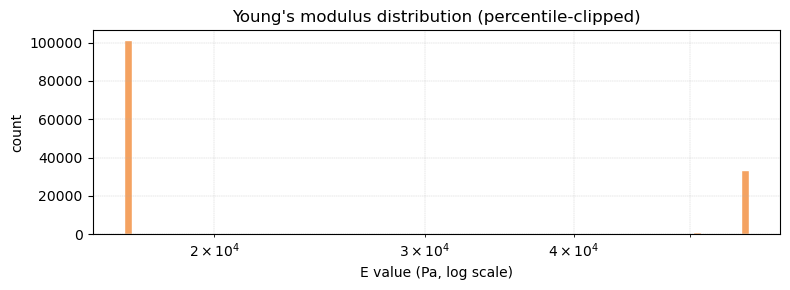

In [28]:
E_mask = (E_values >= E_CLIM[0]) & (E_values <= E_CLIM[1])
E_inliers = E_values[E_mask]
outlier_frac_E = 100.0 * (1.0 - E_inliers.size / E_values.size)

fig, ax = plt.subplots(figsize=(8, 3))
bins = np.logspace(np.log10(E_CLIM[0]), np.log10(E_CLIM[1]), 80)
ax.hist(E_inliers, bins=bins, color='#f4a261', edgecolor='white')
ax.set_xscale('log')
ax.set_xlabel('E value (Pa, log scale)')
ax.set_ylabel('count')
ax.set_title("Young's modulus distribution (percentile-clipped)")
ax.grid(True, which='both', linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
print(f"E inliers: {E_inliers.size}/{E_values.size} ({100.0 - outlier_frac_E:.2f}%); outliers={outlier_frac_E:.2f}%")

display(pd.Series(E_values).describe(percentiles=[0.05, 0.5, 0.95]).to_frame('E'))

In [29]:
surface = pv_mesh.extract_surface()
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(
    surface,
    scalars='E',
    cmap='magma',
    show_edges=False,
    scalar_bar_args={'title': 'E (Pa)'},
    clim=E_CLIM,
)
plotter.show()

Widget(value='<iframe src="http://localhost:39051/index.html?ui=P_0x70e4b6e9be80_4&reconnect=auto" class="pyvi…

## Label-aware mesh view
Highlight specific anatomical label ranges by drawing outer structures with partial opacity and interior regions fully opaque.

In [30]:
if labels is None:
    raise RuntimeError("This visualization requires 'labels' in the XDMF cell data.")

def _parse_range(env_name: str, default: str) -> tuple[float, float]:
    raw = os.environ.get(env_name, default)
    parts = [p.strip() for p in raw.split(',') if p.strip()]
    if len(parts) == 1:
        return float(parts[0]), float(parts[0])
    if len(parts) >= 2:
        return float(parts[0]), float(parts[1])
    raise ValueError(f"Invalid range for {env_name}: '{raw}'")

OUTER_RANGE = _parse_range('SMS_LABEL_OUTER_RANGE', '1,5')
INNER_RANGE = _parse_range('SMS_LABEL_INNER_RANGE', '6,7')
print(f"Outer label range: {OUTER_RANGE}, Inner label range: {INNER_RANGE}")

Outer label range: (1.0, 5.0), Inner label range: (6.0, 7.0)


In [31]:
#pv.set_jupyter_backend('static')
outer_mask = (labels >= OUTER_RANGE[0]) & (labels <= OUTER_RANGE[1])
inner_mask = (labels >= INNER_RANGE[0]) & (labels <= INNER_RANGE[1])

outer_ids = np.where(outer_mask)[0]
inner_ids = np.where(inner_mask)[0]
if outer_ids.size == 0 or inner_ids.size == 0:
    raise RuntimeError(
        f"No cells found for ranges outer={OUTER_RANGE}, inner={INNER_RANGE}; check label ids."
    )

outer_volume = pv_mesh.extract_cells(outer_ids).extract_surface()
inner_volume = pv_mesh.extract_cells(inner_ids).extract_surface()

plotter = pv.Plotter()
plotter.add_mesh(
    outer_volume,
    scalars='labels',
    cmap='Set1',
    clim=(labels.min(), labels.max()),
    opacity=0.5,
)
plotter.add_mesh(
    inner_volume,
    scalars='labels',
    cmap='Set1',
    clim=(labels.min(), labels.max()),
    opacity=1.0,
)
plotter.enable_depth_peeling(10)
plotter.show()

Widget(value='<iframe src="http://localhost:39051/index.html?ui=P_0x70e4b6e9b370_5&reconnect=auto" class="pyvi…


## Slice-by-slice mesh inspection
The triplanar viewer renders PyVista slices off-screen and shows both alpha (top row) and labels (bottom row) for the selected X/Y/Z positions.


In [32]:

# Slice-by-slice inspection helpers
import math

SLICE_AXES = {
    'x': {'bounds_idx': (0, 1), 'center_idx': 0, 'normal': (1.0, 0.0, 0.0), 'view': 'view_yz'},
    'y': {'bounds_idx': (2, 3), 'center_idx': 1, 'normal': (0.0, 1.0, 0.0), 'view': 'view_xz'},
    'z': {'bounds_idx': (4, 5), 'center_idx': 2, 'normal': (0.0, 0.0, 1.0), 'view': 'view_xy'},
}


def _normalize_axis(axis: str) -> str:
    axis = axis.lower()
    if axis not in SLICE_AXES:
        raise ValueError(f"axis must be one of {tuple(SLICE_AXES)}")
    return axis


def _axis_bounds(axis: str) -> tuple[float, float]:
    axis = _normalize_axis(axis)
    idx0, idx1 = SLICE_AXES[axis]['bounds_idx']
    return float(pv_mesh.bounds[idx0]), float(pv_mesh.bounds[idx1])


def axis_midpoint(axis: str) -> float:
    axis_min, axis_max = _axis_bounds(axis)
    return 0.5 * (axis_min + axis_max)


def compute_slice_coords(axis: str = 'z', slices: int = 12, margin: float = 0.02) -> np.ndarray:
    axis = _normalize_axis(axis)
    slices = max(int(slices), 1)
    margin = float(np.clip(margin, 0.0, 0.45))
    axis_min, axis_max = _axis_bounds(axis)
    span = axis_max - axis_min
    if span <= 0.0:
        raise ValueError(f"Mesh bounds collapsed along axis '{axis}'")
    start = axis_min + span * margin
    end = axis_max - span * margin
    if slices == 1:
        return np.array([(start + end) * 0.5])
    return np.linspace(start, end, slices)


def extract_slice(axis: str, coord: float) -> pv.PolyData:
    axis = _normalize_axis(axis)
    origin = list(pv_mesh.center)
    origin[SLICE_AXES[axis]['center_idx']] = float(coord)
    return pv_mesh.slice(normal=SLICE_AXES[axis]['normal'], origin=origin)


def _render_slice_image(
    axis: str,
    coord: float,
    scalars: str,
    clim: tuple[float, float] | None,
    cmap: str,
    show_edges: bool,
    window_size: tuple[int, int] = (600, 600),
):
    cross_section = extract_slice(axis, coord)
    if cross_section.n_points == 0:
        return None
    surface = cross_section.triangulate()
    if surface.n_points == 0:
        return None
    plotter = pv.Plotter(off_screen=True, window_size=window_size)
    plotter.add_mesh(
        surface,
        scalars=scalars,
        cmap=cmap,
        clim=clim,
        show_edges=show_edges,
        edge_color='white',
        lighting=False,
    )
    getattr(plotter, SLICE_AXES[axis]['view'])()
    plotter.enable_parallel_projection()
    plotter.set_background('white')
    img = plotter.screenshot(return_img=True)
    plotter.close()
    return img


def _draw_slice(
    axis_name: str,
    coord: float,
    scalars: str,
    clim,
    cmap: str,
    show_edges: bool,
    ax=None,
    title_prefix: str = '',
):
    if ax is None:
        ax = plt.gca()
    img = _render_slice_image(axis_name, coord, scalars, clim, cmap, show_edges)
    if img is None:
        ax.text(0.5, 0.5, 'empty slice', ha='center', va='center')
        ax.axis('off')
        return
    ax.imshow(img)
    prefix = title_prefix.strip()
    if prefix:
        prefix = prefix + ' '
    ax.set_title(f"{prefix}{axis_name.upper()}={coord:.2f}")
    ax.axis('off')


def plot_slice(
    axis: str = 'z',
    slice_idx: int = 0,
    n_slices: int = 12,
    scalars: str = 'alpha',
    clim=None,
    cmap: str = 'viridis',
    show_edges: bool = True,
) -> float:
    coords = compute_slice_coords(axis=axis, slices=n_slices)
    idx = int(np.clip(slice_idx, 0, len(coords) - 1))
    coord = coords[idx]
    cross_section = extract_slice(axis, coord)
    if cross_section.n_points == 0:
        raise RuntimeError(f"No tetrahedra intersect slice {idx} along the {axis}-axis.")
    surface = cross_section.triangulate()
    if surface.n_points == 0:
        raise RuntimeError(f"Slice {idx} has zero area after triangulation; adjust coordinates.")
    clim = ALPHA_CLIM if clim is None else clim
    plotter = pv.Plotter(notebook=True)
    plotter.add_mesh(
        surface,
        scalars=scalars,
        cmap=cmap,
        clim=clim,
        show_edges=show_edges,
        edge_color='white',
    )
    getattr(plotter, SLICE_AXES[axis]['view'])()
    plotter.enable_parallel_projection()
    plotter.add_text(f"{axis.upper()} slice {idx + 1}/{len(coords)} @ {coord:.2f}", font_size=10)
    plotter.show()
    return coord


def show_slice_grid(
    axis: str = 'z',
    n_slices: int = 9,
    scalars: str = 'alpha',
    n_cols: int = 3,
    clim=None,
    cmap: str = 'viridis',
    show_edges: bool = False,
) -> np.ndarray:
    coords = compute_slice_coords(axis=axis, slices=n_slices)
    n_cols = max(1, int(n_cols))
    n_rows = math.ceil(len(coords) / n_cols)
    clim = ALPHA_CLIM if clim is None else clim
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = np.atleast_1d(axes).reshape(n_rows, n_cols)
    for idx, coord in enumerate(coords):
        row, col = divmod(idx, n_cols)
        ax = axes[row, col]
        _draw_slice(
            axis_name=axis,
            coord=coord,
            scalars=scalars,
            clim=clim,
            cmap=cmap,
            show_edges=show_edges,
            ax=ax,
        )
    for idx in range(len(coords), n_rows * n_cols):
        row, col = divmod(idx, n_cols)
        axes[row, col].axis('off')
    fig.tight_layout()
    return coords


def get_scalar_clim(field: str, fallback=None):
    if field == 'alpha':
        return ALPHA_CLIM
    if field == 'E' and 'E_CLIM' in globals():
        return E_CLIM
    cell_data = pv_mesh.cell_data.get(field)
    if cell_data is None:
        return fallback
    values = np.asarray(cell_data, dtype=float).ravel()
    finite = values[np.isfinite(values)]
    if finite.size == 0:
        return fallback
    lo, hi = np.percentile(finite, [1.0, 99.0])
    if not np.isfinite(lo) or not np.isfinite(hi):
        return fallback
    if lo == hi:
        hi = lo + 1.0
    return float(lo), float(hi)


def plot_triplanar_slices(
    x_coord: float,
    y_coord: float,
    z_coord: float,
    scalars: str = 'alpha',
    clim=None,
    cmap: str = 'viridis',
    show_edges: bool = False,
):
    coords = {'x': x_coord, 'y': y_coord, 'z': z_coord}
    clim = get_scalar_clim(scalars, ALPHA_CLIM if clim is None else clim)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes = np.atleast_1d(axes)
    for ax_obj, axis_name in zip(axes, ('x', 'y', 'z')):
        _draw_slice(
            axis_name=axis_name,
            coord=coords[axis_name],
            scalars=scalars,
            clim=clim,
            cmap=cmap,
            show_edges=show_edges,
            ax=ax_obj,
        )
    fig.tight_layout()
    return fig


def plot_triplanar_with_labels(
    x_coord: float,
    y_coord: float,
    z_coord: float,
    field: str = 'alpha',
    label_field: str = 'labels',
    field_cmap: str = 'viridis',
    label_cmap: str = 'tab20',
    show_edges: bool = False,
):
    coords = {'x': x_coord, 'y': y_coord, 'z': z_coord}
    has_labels = label_field in pv_mesh.cell_data
    rows = 2 if has_labels else 1
    fig, axes = plt.subplots(rows, 3, figsize=(12, 4 * rows))
    axes = np.atleast_2d(axes)
    field_clim = get_scalar_clim(field, ALPHA_CLIM)
    for col, axis_name in enumerate(('x', 'y', 'z')):
        _draw_slice(
            axis_name=axis_name,
            coord=coords[axis_name],
            scalars=field,
            clim=field_clim,
            cmap=field_cmap,
            show_edges=show_edges,
            ax=axes[0, col],
            title_prefix=field,
        )
    if has_labels:
        label_clim = get_scalar_clim(label_field, None)
        for col, axis_name in enumerate(('x', 'y', 'z')):
            _draw_slice(
                axis_name=axis_name,
                coord=coords[axis_name],
                scalars=label_field,
                clim=label_clim,
                cmap=label_cmap,
                show_edges=show_edges,
                ax=axes[1, col],
                title_prefix=label_field,
            )
    else:
        fig.suptitle(f"'{label_field}' field missing; showing {field} only", fontsize=11)
    fig.tight_layout()
    return fig


In [33]:

# Interactive triplanar viewer (alpha + labels)
import ipywidgets as widgets
from IPython.display import display


def _slider_for_axis(axis: str) -> widgets.FloatSlider:
    axis_min, axis_max = _axis_bounds(axis)
    span = axis_max - axis_min
    step = span / 200 if span > 0 else 1e-3
    return widgets.FloatSlider(
        value=axis_midpoint(axis),
        min=axis_min,
        max=axis_max,
        step=step,
        description=f"{axis.upper()} pos",
        readout_format='.4f',
        continuous_update=False,
        layout=widgets.Layout(width='320px'),
    )


x_slider = _slider_for_axis('x')
y_slider = _slider_for_axis('y')
z_slider = _slider_for_axis('z')


def _render_triplanar(x_coord, y_coord, z_coord):
    plt.close('all')
    plot_triplanar_with_labels(
        x_coord=x_coord,
        y_coord=y_coord,
        z_coord=z_coord,
        field='alpha',
        label_field='labels',
        field_cmap='viridis',
        label_cmap='tab20',
        show_edges=False,
    )
    plt.show()


controls = widgets.VBox(
    [x_slider, y_slider, z_slider],
    layout=widgets.Layout(width='340px'),
)
viewer = widgets.interactive_output(
    _render_triplanar,
    {
        'x_coord': x_slider,
        'y_coord': y_slider,
        'z_coord': z_slider,
    },
)
viewer.layout.width = '900px'
display(widgets.HBox([controls, viewer]))
